In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [6]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [8]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [12]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 500
# Amazon stock market
#ticker = "AMZN"
ticker = "8604.T" #Nomura Holdings (JPY)

ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [13]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [14]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/500
70/70 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0458
Epoch 1: val_loss improved from inf to 0.00094, saving model to results\2023-02-16_8604.T-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
70/70 [==============================] - 25s 278ms/step - loss: 0.0025 - mean_absolute_error: 0.0458 - val_loss: 9.3615e-04 - val_mean_absolute_error: 0.0309
Epoch 2/500
70/70 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0360
Epoch 2: val_loss did not improve from 0.00094
70/70 [==============================] - 19s 271ms/step - loss: 0.0013 - mean_absolute_error: 0.0360 - val_loss: 0.0015 - val_mean_absolute_error: 0.0384
Epoch 3/500
70/70 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0355
Epoch 3: val_loss did not improve from 0.00094
70/70 [==============================] - 19s 276ms/step - loss: 0.0013 - mean_absolute_error: 0.0355 - val_loss:

Epoch 48/500
70/70 [==============================] - ETA: 0s - loss: 8.9244e-04 - mean_absolute_error: 0.0291
Epoch 48: val_loss improved from 0.00073 to 0.00073, saving model to results\2023-02-16_8604.T-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
70/70 [==============================] - 19s 275ms/step - loss: 8.9244e-04 - mean_absolute_error: 0.0291 - val_loss: 7.2947e-04 - val_mean_absolute_error: 0.0262
Epoch 49/500
70/70 [==============================] - ETA: 0s - loss: 8.6987e-04 - mean_absolute_error: 0.0290
Epoch 49: val_loss did not improve from 0.00073
70/70 [==============================] - 19s 275ms/step - loss: 8.6987e-04 - mean_absolute_error: 0.0290 - val_loss: 8.3588e-04 - val_mean_absolute_error: 0.0277
Epoch 50/500
70/70 [==============================] - ETA: 0s - loss: 9.9384e-04 - mean_absolute_error: 0.0308
Epoch 50: val_loss did not improve from 0.00073
70/70 [==============================] - 19s 275ms/step - loss: 9.9384e-04 - m

70/70 [==============================] - 19s 275ms/step - loss: 8.3860e-04 - mean_absolute_error: 0.0285 - val_loss: 7.3131e-04 - val_mean_absolute_error: 0.0260
Epoch 73/500
70/70 [==============================] - ETA: 0s - loss: 8.3810e-04 - mean_absolute_error: 0.0284
Epoch 73: val_loss did not improve from 0.00071
70/70 [==============================] - 19s 274ms/step - loss: 8.3810e-04 - mean_absolute_error: 0.0284 - val_loss: 7.6894e-04 - val_mean_absolute_error: 0.0280
Epoch 74/500
70/70 [==============================] - ETA: 0s - loss: 8.4217e-04 - mean_absolute_error: 0.0284
Epoch 74: val_loss improved from 0.00071 to 0.00070, saving model to results\2023-02-16_8604.T-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
70/70 [==============================] - 19s 276ms/step - loss: 8.4217e-04 - mean_absolute_error: 0.0284 - val_loss: 7.0293e-04 - val_mean_absolute_error: 0.0255
Epoch 75/500
70/70 [==============================] - ETA: 0s - loss: 8.613

Epoch 97/500
70/70 [==============================] - ETA: 0s - loss: 8.2803e-04 - mean_absolute_error: 0.0284
Epoch 97: val_loss did not improve from 0.00070
70/70 [==============================] - 20s 282ms/step - loss: 8.2803e-04 - mean_absolute_error: 0.0284 - val_loss: 7.2401e-04 - val_mean_absolute_error: 0.0260
Epoch 98/500
70/70 [==============================] - ETA: 0s - loss: 8.7357e-04 - mean_absolute_error: 0.0290
Epoch 98: val_loss did not improve from 0.00070
70/70 [==============================] - 20s 289ms/step - loss: 8.7357e-04 - mean_absolute_error: 0.0290 - val_loss: 7.4029e-04 - val_mean_absolute_error: 0.0265
Epoch 99/500
70/70 [==============================] - ETA: 0s - loss: 8.9666e-04 - mean_absolute_error: 0.0294
Epoch 99: val_loss did not improve from 0.00070
70/70 [==============================] - 20s 283ms/step - loss: 8.9666e-04 - mean_absolute_error: 0.0294 - val_loss: 7.0484e-04 - val_mean_absolute_error: 0.0254
Epoch 100/500
70/70 [================

70/70 [==============================] - ETA: 0s - loss: 9.7939e-04 - mean_absolute_error: 0.0308
Epoch 122: val_loss did not improve from 0.00070
70/70 [==============================] - 20s 282ms/step - loss: 9.7939e-04 - mean_absolute_error: 0.0308 - val_loss: 8.3161e-04 - val_mean_absolute_error: 0.0279
Epoch 123/500
70/70 [==============================] - ETA: 0s - loss: 8.3553e-04 - mean_absolute_error: 0.0284
Epoch 123: val_loss did not improve from 0.00070
70/70 [==============================] - 20s 284ms/step - loss: 8.3553e-04 - mean_absolute_error: 0.0284 - val_loss: 7.1857e-04 - val_mean_absolute_error: 0.0261
Epoch 124/500
70/70 [==============================] - ETA: 0s - loss: 8.3680e-04 - mean_absolute_error: 0.0284
Epoch 124: val_loss did not improve from 0.00070
70/70 [==============================] - 20s 282ms/step - loss: 8.3680e-04 - mean_absolute_error: 0.0284 - val_loss: 7.1636e-04 - val_mean_absolute_error: 0.0260
Epoch 125/500
70/70 [========================

Epoch 147/500
70/70 [==============================] - ETA: 0s - loss: 8.1778e-04 - mean_absolute_error: 0.0281
Epoch 147: val_loss did not improve from 0.00068
70/70 [==============================] - 21s 299ms/step - loss: 8.1778e-04 - mean_absolute_error: 0.0281 - val_loss: 7.2212e-04 - val_mean_absolute_error: 0.0258
Epoch 148/500
70/70 [==============================] - ETA: 0s - loss: 8.2386e-04 - mean_absolute_error: 0.0284
Epoch 148: val_loss did not improve from 0.00068
70/70 [==============================] - 20s 287ms/step - loss: 8.2386e-04 - mean_absolute_error: 0.0284 - val_loss: 8.0152e-04 - val_mean_absolute_error: 0.0271
Epoch 149/500
70/70 [==============================] - ETA: 0s - loss: 8.4243e-04 - mean_absolute_error: 0.0284
Epoch 149: val_loss did not improve from 0.00068
70/70 [==============================] - 20s 290ms/step - loss: 8.4243e-04 - mean_absolute_error: 0.0284 - val_loss: 7.7064e-04 - val_mean_absolute_error: 0.0277
Epoch 150/500
70/70 [==========

Epoch 172/500
70/70 [==============================] - ETA: 0s - loss: 7.6976e-04 - mean_absolute_error: 0.0271
Epoch 172: val_loss did not improve from 0.00067
70/70 [==============================] - 20s 290ms/step - loss: 7.6976e-04 - mean_absolute_error: 0.0271 - val_loss: 7.0054e-04 - val_mean_absolute_error: 0.0260
Epoch 173/500
70/70 [==============================] - ETA: 0s - loss: 8.0141e-04 - mean_absolute_error: 0.0280
Epoch 173: val_loss did not improve from 0.00067
70/70 [==============================] - 21s 297ms/step - loss: 8.0141e-04 - mean_absolute_error: 0.0280 - val_loss: 8.4279e-04 - val_mean_absolute_error: 0.0285
Epoch 174/500
70/70 [==============================] - ETA: 0s - loss: 8.3756e-04 - mean_absolute_error: 0.0284
Epoch 174: val_loss did not improve from 0.00067
70/70 [==============================] - 21s 296ms/step - loss: 8.3756e-04 - mean_absolute_error: 0.0284 - val_loss: 7.0823e-04 - val_mean_absolute_error: 0.0264
Epoch 175/500
70/70 [==========

Epoch 197/500
70/70 [==============================] - ETA: 0s - loss: 8.0261e-04 - mean_absolute_error: 0.0279
Epoch 197: val_loss did not improve from 0.00067
70/70 [==============================] - 20s 285ms/step - loss: 8.0261e-04 - mean_absolute_error: 0.0279 - val_loss: 6.8007e-04 - val_mean_absolute_error: 0.0253
Epoch 198/500
70/70 [==============================] - ETA: 0s - loss: 7.6176e-04 - mean_absolute_error: 0.0272
Epoch 198: val_loss did not improve from 0.00067
70/70 [==============================] - 20s 288ms/step - loss: 7.6176e-04 - mean_absolute_error: 0.0272 - val_loss: 6.7728e-04 - val_mean_absolute_error: 0.0250
Epoch 199/500
70/70 [==============================] - ETA: 0s - loss: 7.9690e-04 - mean_absolute_error: 0.0277
Epoch 199: val_loss did not improve from 0.00067
70/70 [==============================] - 20s 288ms/step - loss: 7.9690e-04 - mean_absolute_error: 0.0277 - val_loss: 6.7525e-04 - val_mean_absolute_error: 0.0256
Epoch 200/500
70/70 [==========

Epoch 221/500
70/70 [==============================] - ETA: 0s - loss: 7.6308e-04 - mean_absolute_error: 0.0273
Epoch 221: val_loss improved from 0.00064 to 0.00063, saving model to results\2023-02-16_8604.T-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
70/70 [==============================] - 20s 291ms/step - loss: 7.6308e-04 - mean_absolute_error: 0.0273 - val_loss: 6.3389e-04 - val_mean_absolute_error: 0.0243
Epoch 222/500
70/70 [==============================] - ETA: 0s - loss: 7.5599e-04 - mean_absolute_error: 0.0272
Epoch 222: val_loss did not improve from 0.00063
70/70 [==============================] - 20s 291ms/step - loss: 7.5599e-04 - mean_absolute_error: 0.0272 - val_loss: 6.6867e-04 - val_mean_absolute_error: 0.0251
Epoch 223/500
70/70 [==============================] - ETA: 0s - loss: 7.4860e-04 - mean_absolute_error: 0.0272
Epoch 223: val_loss did not improve from 0.00063
70/70 [==============================] - 21s 293ms/step - loss: 7.4860e-

Epoch 246/500
70/70 [==============================] - ETA: 0s - loss: 7.6191e-04 - mean_absolute_error: 0.0271
Epoch 246: val_loss did not improve from 0.00063
70/70 [==============================] - 22s 311ms/step - loss: 7.6191e-04 - mean_absolute_error: 0.0271 - val_loss: 6.6399e-04 - val_mean_absolute_error: 0.0247
Epoch 247/500
70/70 [==============================] - ETA: 0s - loss: 7.8120e-04 - mean_absolute_error: 0.0274
Epoch 247: val_loss did not improve from 0.00063
70/70 [==============================] - 23s 332ms/step - loss: 7.8120e-04 - mean_absolute_error: 0.0274 - val_loss: 6.9837e-04 - val_mean_absolute_error: 0.0253
Epoch 248/500
70/70 [==============================] - ETA: 0s - loss: 7.7986e-04 - mean_absolute_error: 0.0276
Epoch 248: val_loss did not improve from 0.00063
70/70 [==============================] - 23s 332ms/step - loss: 7.7986e-04 - mean_absolute_error: 0.0276 - val_loss: 6.6970e-04 - val_mean_absolute_error: 0.0248
Epoch 249/500
70/70 [==========

Epoch 271/500
70/70 [==============================] - ETA: 0s - loss: 7.5041e-04 - mean_absolute_error: 0.0269
Epoch 271: val_loss did not improve from 0.00061
70/70 [==============================] - 21s 296ms/step - loss: 7.5041e-04 - mean_absolute_error: 0.0269 - val_loss: 6.2937e-04 - val_mean_absolute_error: 0.0242
Epoch 272/500
70/70 [==============================] - ETA: 0s - loss: 7.2599e-04 - mean_absolute_error: 0.0266
Epoch 272: val_loss did not improve from 0.00061
70/70 [==============================] - 21s 298ms/step - loss: 7.2599e-04 - mean_absolute_error: 0.0266 - val_loss: 6.3186e-04 - val_mean_absolute_error: 0.0244
Epoch 273/500
70/70 [==============================] - ETA: 0s - loss: 7.3193e-04 - mean_absolute_error: 0.0267
Epoch 273: val_loss did not improve from 0.00061
70/70 [==============================] - 22s 313ms/step - loss: 7.3193e-04 - mean_absolute_error: 0.0267 - val_loss: 6.5127e-04 - val_mean_absolute_error: 0.0249
Epoch 274/500
70/70 [==========

Epoch 296/500
70/70 [==============================] - ETA: 0s - loss: 7.2015e-04 - mean_absolute_error: 0.0266
Epoch 296: val_loss did not improve from 0.00060
70/70 [==============================] - 20s 293ms/step - loss: 7.2015e-04 - mean_absolute_error: 0.0266 - val_loss: 7.0465e-04 - val_mean_absolute_error: 0.0258
Epoch 297/500
70/70 [==============================] - ETA: 0s - loss: 7.2177e-04 - mean_absolute_error: 0.0266
Epoch 297: val_loss did not improve from 0.00060
70/70 [==============================] - 21s 294ms/step - loss: 7.2177e-04 - mean_absolute_error: 0.0266 - val_loss: 6.2167e-04 - val_mean_absolute_error: 0.0243
Epoch 298/500
70/70 [==============================] - ETA: 0s - loss: 7.2489e-04 - mean_absolute_error: 0.0266
Epoch 298: val_loss did not improve from 0.00060
70/70 [==============================] - 21s 294ms/step - loss: 7.2489e-04 - mean_absolute_error: 0.0266 - val_loss: 6.2909e-04 - val_mean_absolute_error: 0.0248
Epoch 299/500
70/70 [==========

70/70 [==============================] - 20s 293ms/step - loss: 7.2690e-04 - mean_absolute_error: 0.0267 - val_loss: 6.2758e-04 - val_mean_absolute_error: 0.0249
Epoch 322/500
70/70 [==============================] - ETA: 0s - loss: 7.1278e-04 - mean_absolute_error: 0.0266
Epoch 322: val_loss did not improve from 0.00060
70/70 [==============================] - 21s 293ms/step - loss: 7.1278e-04 - mean_absolute_error: 0.0266 - val_loss: 6.1086e-04 - val_mean_absolute_error: 0.0243
Epoch 323/500
70/70 [==============================] - ETA: 0s - loss: 6.9293e-04 - mean_absolute_error: 0.0261
Epoch 323: val_loss improved from 0.00060 to 0.00059, saving model to results\2023-02-16_8604.T-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
70/70 [==============================] - 20s 293ms/step - loss: 6.9293e-04 - mean_absolute_error: 0.0261 - val_loss: 5.9217e-04 - val_mean_absolute_error: 0.0238
Epoch 324/500
70/70 [==============================] - ETA: 0s - loss: 

70/70 [==============================] - 20s 291ms/step - loss: 6.6451e-04 - mean_absolute_error: 0.0255 - val_loss: 6.0034e-04 - val_mean_absolute_error: 0.0238
Epoch 346/500
70/70 [==============================] - ETA: 0s - loss: 6.8617e-04 - mean_absolute_error: 0.0259
Epoch 346: val_loss did not improve from 0.00057
70/70 [==============================] - 20s 292ms/step - loss: 6.8617e-04 - mean_absolute_error: 0.0259 - val_loss: 5.7453e-04 - val_mean_absolute_error: 0.0235
Epoch 347/500
70/70 [==============================] - ETA: 0s - loss: 6.7274e-04 - mean_absolute_error: 0.0256
Epoch 347: val_loss did not improve from 0.00057
70/70 [==============================] - 20s 292ms/step - loss: 6.7274e-04 - mean_absolute_error: 0.0256 - val_loss: 6.3224e-04 - val_mean_absolute_error: 0.0248
Epoch 348/500
70/70 [==============================] - ETA: 0s - loss: 6.7057e-04 - mean_absolute_error: 0.0257
Epoch 348: val_loss did not improve from 0.00057
70/70 [========================

70/70 [==============================] - 21s 303ms/step - loss: 6.8635e-04 - mean_absolute_error: 0.0255 - val_loss: 5.6686e-04 - val_mean_absolute_error: 0.0235
Epoch 371/500
70/70 [==============================] - ETA: 0s - loss: 6.5332e-04 - mean_absolute_error: 0.0253
Epoch 371: val_loss did not improve from 0.00056
70/70 [==============================] - 21s 302ms/step - loss: 6.5332e-04 - mean_absolute_error: 0.0253 - val_loss: 6.2663e-04 - val_mean_absolute_error: 0.0243
Epoch 372/500
70/70 [==============================] - ETA: 0s - loss: 6.5541e-04 - mean_absolute_error: 0.0253
Epoch 372: val_loss did not improve from 0.00056
70/70 [==============================] - 22s 309ms/step - loss: 6.5541e-04 - mean_absolute_error: 0.0253 - val_loss: 6.2534e-04 - val_mean_absolute_error: 0.0240
Epoch 373/500
70/70 [==============================] - ETA: 0s - loss: 7.1351e-04 - mean_absolute_error: 0.0260
Epoch 373: val_loss did not improve from 0.00056
70/70 [========================

70/70 [==============================] - 22s 313ms/step - loss: 7.2843e-04 - mean_absolute_error: 0.0266 - val_loss: 6.2531e-04 - val_mean_absolute_error: 0.0246
Epoch 396/500
70/70 [==============================] - ETA: 0s - loss: 7.0563e-04 - mean_absolute_error: 0.0265
Epoch 396: val_loss did not improve from 0.00055
70/70 [==============================] - 23s 323ms/step - loss: 7.0563e-04 - mean_absolute_error: 0.0265 - val_loss: 6.5218e-04 - val_mean_absolute_error: 0.0243
Epoch 397/500
70/70 [==============================] - ETA: 0s - loss: 7.5122e-04 - mean_absolute_error: 0.0272
Epoch 397: val_loss did not improve from 0.00055
70/70 [==============================] - 24s 340ms/step - loss: 7.5122e-04 - mean_absolute_error: 0.0272 - val_loss: 6.4759e-04 - val_mean_absolute_error: 0.0244
Epoch 398/500
70/70 [==============================] - ETA: 0s - loss: 7.0775e-04 - mean_absolute_error: 0.0263
Epoch 398: val_loss did not improve from 0.00055
70/70 [========================

Epoch 421/500
70/70 [==============================] - ETA: 0s - loss: 6.5680e-04 - mean_absolute_error: 0.0254
Epoch 421: val_loss did not improve from 0.00055
70/70 [==============================] - 25s 356ms/step - loss: 6.5680e-04 - mean_absolute_error: 0.0254 - val_loss: 5.6870e-04 - val_mean_absolute_error: 0.0235
Epoch 422/500
70/70 [==============================] - ETA: 0s - loss: 6.6212e-04 - mean_absolute_error: 0.0255
Epoch 422: val_loss did not improve from 0.00055
70/70 [==============================] - 25s 358ms/step - loss: 6.6212e-04 - mean_absolute_error: 0.0255 - val_loss: 6.6954e-04 - val_mean_absolute_error: 0.0256
Epoch 423/500
70/70 [==============================] - ETA: 0s - loss: 6.8476e-04 - mean_absolute_error: 0.0259
Epoch 423: val_loss did not improve from 0.00055
70/70 [==============================] - 25s 360ms/step - loss: 6.8476e-04 - mean_absolute_error: 0.0259 - val_loss: 5.6156e-04 - val_mean_absolute_error: 0.0231
Epoch 424/500
70/70 [==========

Epoch 445/500
70/70 [==============================] - ETA: 0s - loss: 6.2335e-04 - mean_absolute_error: 0.0250
Epoch 445: val_loss did not improve from 0.00052
70/70 [==============================] - 25s 352ms/step - loss: 6.2335e-04 - mean_absolute_error: 0.0250 - val_loss: 5.7059e-04 - val_mean_absolute_error: 0.0236
Epoch 446/500
70/70 [==============================] - ETA: 0s - loss: 6.5727e-04 - mean_absolute_error: 0.0257
Epoch 446: val_loss did not improve from 0.00052
70/70 [==============================] - 25s 360ms/step - loss: 6.5727e-04 - mean_absolute_error: 0.0257 - val_loss: 5.8889e-04 - val_mean_absolute_error: 0.0237
Epoch 447/500
70/70 [==============================] - ETA: 0s - loss: 6.8125e-04 - mean_absolute_error: 0.0257
Epoch 447: val_loss did not improve from 0.00052
70/70 [==============================] - 24s 346ms/step - loss: 6.8125e-04 - mean_absolute_error: 0.0257 - val_loss: 5.5633e-04 - val_mean_absolute_error: 0.0241
Epoch 448/500
70/70 [==========

70/70 [==============================] - ETA: 0s - loss: 6.1582e-04 - mean_absolute_error: 0.0246
Epoch 493: val_loss did not improve from 0.00045
70/70 [==============================] - 21s 306ms/step - loss: 6.1582e-04 - mean_absolute_error: 0.0246 - val_loss: 5.3995e-04 - val_mean_absolute_error: 0.0231
Epoch 494/500
70/70 [==============================] - ETA: 0s - loss: 5.7496e-04 - mean_absolute_error: 0.0241
Epoch 494: val_loss did not improve from 0.00045
70/70 [==============================] - 21s 306ms/step - loss: 5.7496e-04 - mean_absolute_error: 0.0241 - val_loss: 5.5454e-04 - val_mean_absolute_error: 0.0231
Epoch 495/500
70/70 [==============================] - ETA: 0s - loss: 6.0490e-04 - mean_absolute_error: 0.0245
Epoch 495: val_loss improved from 0.00045 to 0.00044, saving model to results\2023-02-16_8604.T-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
70/70 [==============================] - 21s 306ms/step - loss: 6.0490e-04 - mean_abso

In [34]:
import matplotlib.pyplot as plt


def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [35]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [36]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# predict the future price
future_price = predict(model, data)

1/1 [==============================] - 0s 25ms/step


In [37]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

Future price after 2 days is 536.70$
huber_loss loss: 0.0004430218832567334
Mean Absolute Error: 201.17931750212585
Accuracy score: 0.9529411764705882
Total buy profit: 228067.30641174316
Total sell profit: 231524.71296691895
Total profit: 459592.0193786621
Profit per trade: 415.920379528201


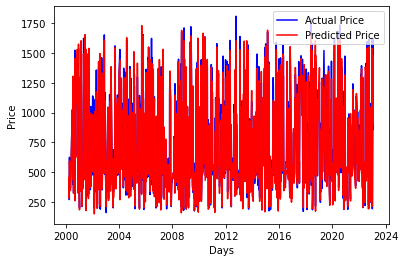

In [38]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

# plot true/pred prices graph
plot_graph(final_df)

In [27]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                  open        high         low       close    adjclose  \
2022-11-17  491.399994  493.399994  490.299988  493.399994  493.399994   
2022-11-22  490.299988  496.799988  489.799988  494.899994  494.899994   
2022-11-25  499.000000  503.399994  497.500000  502.500000  502.500000   
2022-12-02  496.899994  496.899994  488.700012  492.500000  492.500000   
2022-12-14  489.600006  491.700012  487.799988  488.799988  488.799988   
2022-12-16  484.000000  486.000000  479.600006  480.000000  480.000000   
2022-12-23  480.000000  483.799988  479.799988  483.299988  483.299988   
2022-12-30  488.799988  492.700012  486.700012  488.600006  488.600006   
2023-01-18  509.600006  515.599976  504.500000  513.000000  513.000000   
2023-01-25  514.000000  518.500000  512.799988  517.000000  517.000000   

                volume  ticker  adjclose_15  true_adjclose_15   buy_profit  \
2022-11-17   5755500.0  8604.T   438.528168        480.168427     0.000000   
2022-11-22   7929800.0  8604.

In [ ]:
##########################

In [4]:
df = pd.read_csv('stock_data.csv')

FileNotFoundError: [Errno 2] File stock_data.csv does not exist: 'stock_data.csv'

In [ ]:
#Prepare the data for the LSTM model by scaling the values between 0 and 1:

scaler = MinMaxScaler()
data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [ ]:
#Split the data into training and testing sets:

train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

In [ ]:
#Create the function to generate the training data for the LSTM model:

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
#Generate the training data using the create_dataset function:

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#Define the LSTM model and compile it:

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
#train

history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_test, Y_test))

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#Make stock price predictions using the trained LSTM model:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [ ]:
plt.plot(Y_test[0], label='Actual Price')
plt.plot(test_predict[:,0], label='Predict